# **PADI — Phase-Adjusted Decision Index**

**Author:** Gabriel Carbinatto (gabrielcarbinatto@usp.br)  
**Repository:** `gcarbs1/analytics_cup_research`

## **Introduction**

This notebook implements and validates PADI (Phase-Adjusted Decision Index), a metric for evaluating passing decision quality in soccer that accounts for game phase context.

## **Proposed Metric**  
Traditional passing metrics evaluate all passes identically, regardless of tactical context. PADI recognizes that optimal decisions vary by game phase—aggressive progression during build-up versus cautious retention during transitions. Phase-specific weights are estimated from actual player behavior via logistic regression, grounding the metric in observed tactical decision-making.

## **Data Sources**
- SkillCorner Dynamic Events: Possession events and passing options with xThreat/xPass values
- SkillCorner Phases of Play: Temporal phase labels (build_up, create, finish, etc.)
- SofaScore Expert Ratings: For validation (10 A-League matches, 202 player-matches)

## **1. Setup and Imports**

In [1]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Tuple
from scipy.stats import pearsonr
import warnings
import os

warnings.filterwarnings('ignore')

sys.path.append("src")
from get_data import SkillCornerCollector
from sofascore_data import load_sofascore_data
from name_matching import merge_with_fuzzy_matching
from padi_utils import (
    filter_pass_decisions,
    get_passing_options,
    attach_phases,
    estimate_phase_weights,
    compute_padi,
    load_player_minutes,
    aggregate_player_match
)
from plotting_utils import plot_padi_correlation

os.makedirs("viz", exist_ok=True)
os.makedirs("data/raw", exist_ok=True)

## **2. Data Download**

SkillCorner open data is retrieved via git-lfs. The data is organized into CSV files for dynamic events (player possessions and passing options) and phases of play.

In [2]:
repo_dir = "opendata_repo"
raw_data_dir = "data/raw"

dynamic_events_dir = Path(raw_data_dir) / "dynamic_events"

if dynamic_events_dir.exists() and list(dynamic_events_dir.glob("*.csv")):
    print(f"Data already downloaded. {len(list(dynamic_events_dir.glob('*.csv')))} dynamic_events files found.")
else:
    print("Downloading SkillCorner data...")
    collector = SkillCornerCollector(repo_dir=repo_dir, data_root=raw_data_dir)
    summary = collector.prepare_data()
    print(f"Data downloaded for {len(summary)} matches")

Data already downloaded. 10 dynamic_events files found.


## **3. Load Data**

Load and concatenate CSV files across all matches to create unified dataframes:
- **Dynamic Events**: Contains player possession events and passing options with xThreat/xPass values
- **Phases of Play**: Temporal intervals with phase type labels

In [3]:
def load_data(raw_data_dir: str = "data/raw") -> Tuple[pd.DataFrame, pd.DataFrame]:
    raw_path = Path(raw_data_dir)
    
    dynamic_events_files = sorted((raw_path / "dynamic_events").glob("*.csv"))
    print(f"Loading {len(dynamic_events_files)} dynamic_events files...")
    df_dynamic_events = pd.concat(
        [pd.read_csv(f, low_memory=False) for f in dynamic_events_files],
        ignore_index=True
    )
    print(f"  {len(df_dynamic_events):,} events loaded")

    phases_files = sorted((raw_path / "phases_of_play").glob("*.csv"))
    print(f"Loading {len(phases_files)} phases_of_play files...")
    df_phases = pd.concat(
        [pd.read_csv(f, low_memory=False) for f in phases_files],
        ignore_index=True
    )
    print(f"  {len(df_phases):,} phases loaded")
    
    return df_dynamic_events, df_phases

df_dynamic_events, df_phases = load_data()

Loading 10 dynamic_events files...
  47,853 events loaded
Loading 10 phases_of_play files...
  4,581 phases loaded


## **4. Prepare Pass Data**

Extract player possession events that ended in passes. This involves:
- Filtering for possession events with pass outcomes
- Parsing timestamps to enable temporal matching with phases
- Extracting passer information (ID, name, position)

**Note:** Goalkeepers are excluded as their passing decisions follow fundamentally different tactical logic.

In [4]:
df_pass = filter_pass_decisions(df_dynamic_events)

8,585 valid passes (204 players)


## **5. Retrieve Passing Options**

For each possession event, SkillCorner provides the set of available passing options. Each option includes:
- **xThreat**: Expected threat value (offensive potential)
- **xPass**: Completion probability (safety)
- **Contextual variables**: Defensive pressure and risk factors (n_opponents_ahead_pass_reception, n_opponents_bypassed, n_simultaneous_passing_options, dangerous and difficult_pass_target )

These options form the choice set from which the player selected their actual pass. Decision quality is assessed by comparing the chosen option's rank against all alternatives.

In [5]:
df_passing_options = get_passing_options(df_dynamic_events)

24,374 valid passing_options (1,057 possessions)


## **6. Associate Phases to Passes**

**Core Hypothesis:**  
Passing decision making varies systematically across game phases. Players prioritize different objectives, progression versus retention, depending on tactical context.

**Implementation:**  
Each pass is matched to the phase of play occurring at that moment via temporal join, accounting for match period timing.

In [6]:
df_pass_with_phase = attach_phases(df_pass, df_phases)

Phases attached
Distribution: {'create': 3499, 'finish': 1936, 'build_up': 1550, 'chaotic': 888, 'set_play': 275, 'transition': 193, 'direct': 140, 'quick_break': 100, 'default': 4}


## **7. Estimate Phase Weights via Logistic Regression**

### **Approach**

For each phase, construct a dataset where rows represent available passing options and the outcome is whether that option was chosen. Fit a logistic regression model:

```
P(chosen) = logistic(β_T × S_T + β_P × S_P + controls)
```

Where:
- **S_T, S_P**: Normalized threat and safety scores (primary variables)
- **Controls**: Defensive pressure (opponents ahead, bypassed, simultaneous options) and risk (dangerous area, difficult target)

The estimated coefficients β_T and β_P reveal the relative weight players place on threat versus safety in that phase. Normalize these to sum to 1, yielding phase-specific weights w_T and w_P.

In [7]:
PHASE_WEIGHTS, df_weight_diagnostics = estimate_phase_weights(
    df_pass_with_phase,
    df_passing_options
)

In [8]:
print("Phase-Specific Weights (sorted by threat priority):")
print("=" * 50)
for phase in sorted(PHASE_WEIGHTS.keys(), key=lambda x: PHASE_WEIGHTS[x]['wT'], reverse=True):
    wT = PHASE_WEIGHTS[phase]['wT']
    wP = PHASE_WEIGHTS[phase]['wP']
    print(f"{phase:15s} | wT={wT:.3f}, wP={wP:.3f}")

Phase-Specific Weights (sorted by threat priority):
build_up        | wT=0.888, wP=0.112
set_play        | wT=0.850, wP=0.150
quick_break     | wT=0.846, wP=0.154
finish          | wT=0.610, wP=0.390
default         | wT=0.500, wP=0.500
chaotic         | wT=0.330, wP=0.670
direct          | wT=0.246, wP=0.754
create          | wT=0.058, wP=0.942
transition      | wT=0.034, wP=0.966


## **8. Compute PADI Values**

With phase-specific weights established, calculate PADI for each passing decision:

1. For each pass, rank all N available options by xThreat and xPass (1 = best)

2. Compute normalized scores based on chosen option's rank:
   - $S_T = \frac{N - \text{rank}_T + 1}{N}$
   - $S_P = \frac{N - \text{rank}_P + 1}{N}$

3. Apply phase-specific weights to compute quality score:
   - $Q = \frac{S_T + S_P}{\frac{S_T}{w_T} + \frac{S_P}{w_P}}$

4. Scale by chosen xThreat and apply power transformation:
   - $PADI = (Q \times xT_{\text{chosen}})^{0.25}$

**Power transformation rationale:** Ensures reasonable scale and reduces influence of extreme xThreat values.

In [9]:
df_pass_decisions = compute_padi(
    df_pass_with_phase,
    df_passing_options,
    PHASE_WEIGHTS
)

print(f"✓ {len(df_pass_decisions):,} decisions analyzed")
print(f"Average PADI value: {df_pass_decisions['PADI_value'].mean():.4f}")

✓ 7,417 decisions analyzed
Average PADI value: 0.1581


## **9. Load Minutes Played**

To aggregate PADI at the player-match level, we need playing time information for minimum threshold filters. This ensures we only evaluate players with sufficient opportunity to demonstrate passing ability.

Minutes played data is extracted from SkillCorner match metadata JSON files.

In [10]:
df_minutes_played = load_player_minutes()

✓ Minutes loaded: 360 player-match combinations


## **10. Player-Match Aggregation**

### **Aggregation Strategy**

Aggregate individual PADI values using **median** rather than mean:
- **Robustness**: Less sensitive to outliers from unusual tactical situations
- **Consistency focus**: Better captures typical decision quality rather than being skewed by exceptional or poor choices

### **Filtering Criteria**

Apply minimum thresholds to ensure statistical reliability:
- **45+ minutes played**: Sufficient sample of tactical situations
- **5+ passes**: Minimum number of decisions to evaluate

These filters reduce noise from limited playing time or passing involvement.

In [32]:
def aggregate_player_match(
    df_decisions: pd.DataFrame,
    df_minutes: pd.DataFrame
) -> pd.DataFrame:
    """
    Aggregate PADI values by player-match and merge with minutes played.

    Computes 75th percentile PADI value and pass count for each player-match combination,
    then merges with playing time information.

    Args:
        df_decisions: DataFrame with PADI values for each decision
        df_minutes: DataFrame with player minutes played

    Returns:
        DataFrame with aggregated player-match statistics
    """
    df_agg = df_decisions.groupby(['passer_id', 'passer_name', 'match_id']).agg(
        n_pass=('xT_chosen', 'count'),
        PADI_value_p75=('PADI_value', lambda x: x.quantile(0.55)),
        position=('passer_position', lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]),
    ).reset_index()

    df_agg = df_agg.merge(
        df_minutes[['player_id', 'match_id', 'minutes_played']],
        left_on=['passer_id', 'match_id'],
        right_on=['player_id', 'match_id'],
        how='left'
    ).drop(columns=['player_id'])

    df_agg['minutes_played'] = df_agg['minutes_played'].fillna(0.0)

    df_agg = df_agg.rename(columns={
        'passer_id': 'player_id',
        'passer_name': 'player_name',
        'position': 'player_position'
    })

    return df_agg

In [33]:
df_player_match = aggregate_player_match(df_pass_decisions, df_minutes_played)

df_team_info = df_pass_with_phase.groupby(['player_id', 'match_id']).agg(
    team_name=('team_shortname', lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0])
).reset_index()
df_player_match = df_player_match.merge(df_team_info, on=['player_id', 'match_id'], how='left')

df_player_match_filtered = df_player_match[
    (df_player_match['minutes_played'] >= 45.0) &
    (df_player_match['n_pass'] >= 5)
].copy()

position_map = {
    "CF": "FW", "LW": "FW", "RW": "FW", "LF": "FW", "RF": "FW",
    "RM": "MF", "LM": "MF", "AM": "MF", "DM": "MF", "LDM": "MF", "RDM": "MF",
    "LCB": "DEF", "RCB": "DEF", "CB": "DEF", "LB": "DEF", "RB": "DEF", "LWB": "DEF", "RWB": "DEF",
}
df_player_match_filtered['position_group'] = df_player_match_filtered['player_position'].map(position_map)
df_player_match_filtered = df_player_match_filtered.sort_values('PADI_value_p75', ascending=False).reset_index(drop=True)

print(f"\n✓ {len(df_player_match_filtered)} player-matches after filters")
print(f"  - Unique players: {df_player_match_filtered['player_id'].nunique()}")
print(f"  - Unique matches: {df_player_match_filtered['match_id'].nunique()}")


✓ 202 player-matches after filters
  - Unique players: 140
  - Unique matches: 10


In [34]:
df_player_match_filtered.head()

,player_id,player_name,match_id,n_pass,PADI_value_p75,player_position,minutes_played,team_name,position_group
0,795537,T. Waddingham,1925299,6,0.341590,CF,102.13,Brisbane FC,FW
1,29075,N. Vergos,2017461,9,0.303623,CF,70.23,Melbourne V FC,FW
2,17231,P. Klimala,1996435,11,0.286465,CF,83.40,Sydney FC,FW
3,38673,G. May,1886347,16,0.284666,CF,86.65,Auckland FC,FW
4,133853,J. Kucharski,2013725,8,0.282225,RW,62.23,Sydney FC,FW


## **11. Load SofaScore Ratings for Validation**

### **Validation Strategy**

Validate PADI against expert ratings from SofaScore, which provides holistic player ratings (0-10 scale) considering multiple performance dimensions.

In [35]:
df_sofascore = load_sofascore_data()
print(f"✓ {len(df_sofascore)} SofaScore ratings loaded")
print(f"✓ {df_sofascore['match_id'].nunique()} matches with ratings")

✓ 303 SofaScore ratings loaded
✓ 10 matches with ratings


In [36]:
df_merged = merge_with_fuzzy_matching(
    df_main=df_player_match_filtered,
    df_reference=df_sofascore,
    match_id_col='match_id',
    verbose=True
)

print(f"\nPlayers with rating: {df_merged['sofascore_rating'].notna().sum()}")
print(f"Players without rating: {df_merged['sofascore_rating'].isna().sum()}")

Processing match 1925299...
  Matched: 20/20 players (avg confidence: 96.4)
Processing match 2017461...
  Matched: 19/19 players (avg confidence: 96.8)
Processing match 1996435...
  Matched: 19/19 players (avg confidence: 97.6)
Processing match 1886347...
  Matched: 20/20 players (avg confidence: 97.7)
Processing match 2013725...
  Matched: 20/20 players (avg confidence: 97.2)
Processing match 1899585...
  Matched: 20/20 players (avg confidence: 98.6)
Processing match 2011166...
  Matched: 20/20 players (avg confidence: 90.7)
Processing match 2015213...
  Matched: 24/24 players (avg confidence: 92.5)
Processing match 2006229...
  Matched: 21/21 players (avg confidence: 98.7)
Processing match 1953632...
  Matched: 19/19 players (avg confidence: 95.1)

Players with rating: 202
Players without rating: 0


## **12. Correlation Analysis: PADI vs SofaScore**

### **Statistical Method**

Use Pearson correlation coefficient (ρ) to measure linear relationship between PADI and SofaScore ratings:
1. Overall across all positions
2. Separately for each position group (DEF, MF, FW)

The p-value tests the null hypothesis of zero correlation. Values p < 0.05 indicate statistically significant evidence of a relationship.

### **Interpreting Correlation Strength**
- ρ < 0.3: Weak
- 0.3 ≤ ρ < 0.5: Moderate  
- ρ ≥ 0.5: Strong

In [37]:
df_analysis = df_merged[df_merged['sofascore_rating'].notna()].copy()

corr_value, p_value = pearsonr(
    df_analysis['PADI_value_p75'],
    df_analysis['sofascore_rating']
)

print("OVERALL (all positions):")
print(f"  PADI vs SofaScore: ρ = {corr_value:.4f} (p = {p_value:.4f})")

print("\nBY POSITION:")
correlations = []

for position in sorted(df_analysis['position_group'].unique()):
    df_pos = df_analysis[df_analysis['position_group'] == position]
    n = len(df_pos)
    
    if n < 3:
        continue
    
    corr_v, p_v = pearsonr(
        df_pos['PADI_value_p75'],
        df_pos['sofascore_rating']
    )
    
    correlations.append({
        'position': position,
        'n': n,
        'ρ': corr_v,
        'p-value': p_v
    })

df_corr = pd.DataFrame(correlations)
print(df_corr.to_string(index=False))

OVERALL (all positions):
  PADI vs SofaScore: ρ = 0.2456 (p = 0.0004)

BY POSITION:
position  n        ρ  p-value
     DEF 85 0.232753 0.032062
      FW 63 0.290972 0.020691
      MF 54 0.490790 0.000165


### **Visualization: PADI Distribution and Correlation by Position**

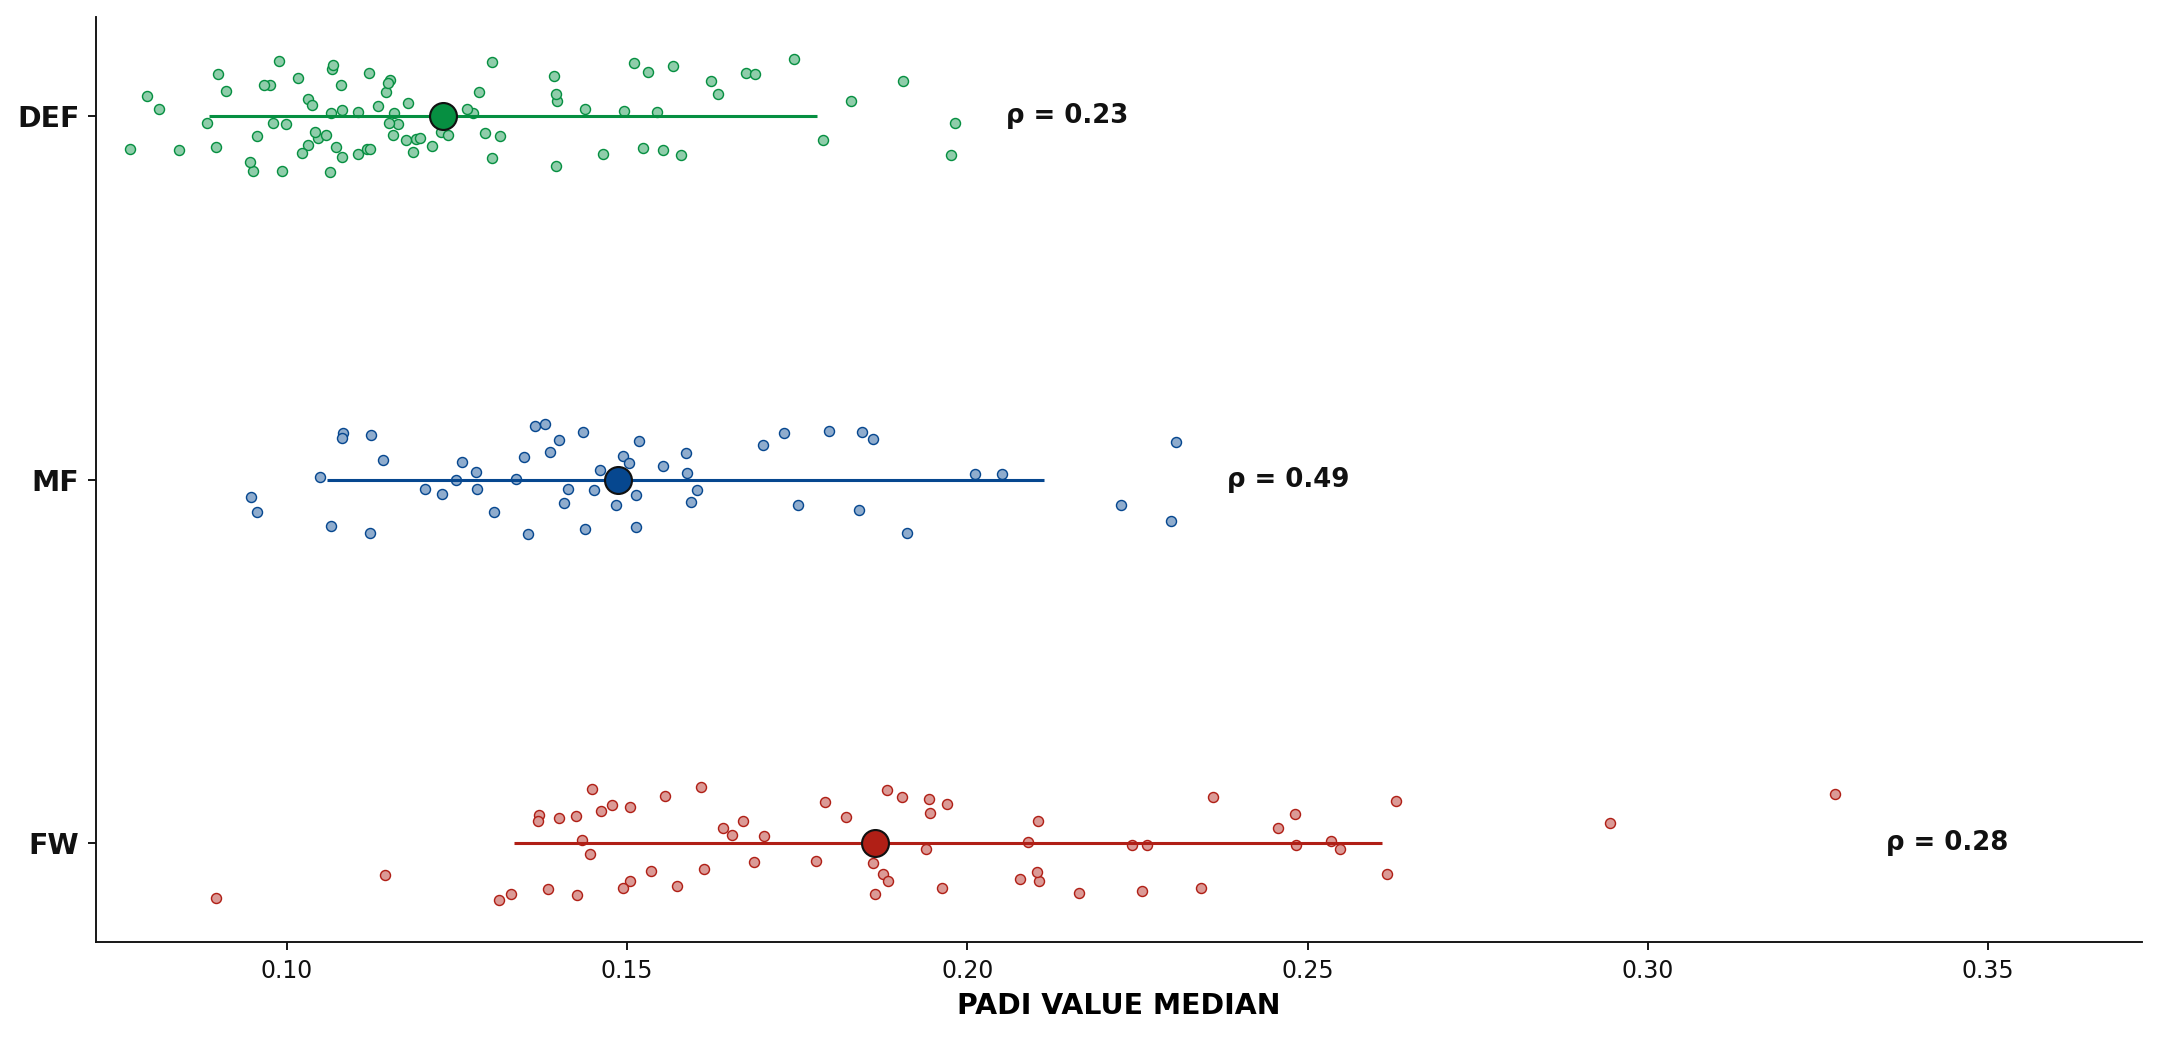

Figure saved to viz/padi_correlation_plot.png


In [ ]:
plot_padi_correlation(df_merged)

## **Interpretation of Results**

### **Overall Correlation**

The overall correlation of ρ = 0.24 (p < 0.001) is weak but highly significant. PADI captures some aspect of player quality aligning with expert evaluations, though it explains only a modest portion of variance in SofaScore ratings.

### **Position-Specific Patterns**

Position-level analysis reveals expected heterogeneity:

1. **Midfielders** (ρ = 0.49, p < 0.001): **Moderate positive correlation** validates that PADI effectively captures performance aspects central to midfielder evaluation. Passing decisions and progression are primary responsibilities.

2. **Forwards** (ρ = 0.28, p = 0.027): **Weak but significant correlation**. Expected because SofaScore heavily weights goals and assists for forwards, which PADI does not measure. The weak positive relationship suggests PADI captures playmaking quality contributing to overall forward performance.

3. **Defenders** (ρ = 0.23, p = 0.034): **Weak but significant correlation**. Defensive actions (tackles, blocks, interceptions) dominate defender ratings but are not captured by PADI. The positive relationship indicates passing quality contributes modestly to defender evaluation.